In [2]:
import os
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, create_map
from pyspark.ml.feature import VectorAssembler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import joblib

# Configurations
DATASET_FILE = "../dataset/preprocess_swat.csv"
MODEL_PATH = "models/swat_1dcnn_model"
SELECTED_FEATURES = [
    "FIT101", "LIT101", "MV101", "P101", "P102", 
    "AIT201", "AIT202", "AIT203", "FIT201", "MV201", 
    "P201", "P203", "P204", "P205", "P206", 
    "DPIT301", "FIT301", "LIT301", "MV301", "MV302", 
    "MV303", "MV304", "P302", "AIT401", "AIT402", 
    "FIT401", "LIT401", "P402", "UV401", "AIT501", 
    "AIT502", "AIT503", "AIT504", "FIT501", "FIT502", 
    "FIT503", "FIT504", "P501", "PIT501", "PIT502", 
    "PIT503", "FIT601", "P602"
]
LABEL_COLUMN = "Normal/Attack"

# Initialize Spark Session
spark = SparkSession.builder.appName("SWaT_1D_CNN_Model_Local_Training").getOrCreate()

# Load Dataset
data = spark.read.csv(DATASET_FILE, header=True, inferSchema=True)

# Map "Normal/Attack" to Numeric Labels
data = data.withColumn("Label", (col(LABEL_COLUMN) == "Attack").cast("int")).drop(LABEL_COLUMN)

# Assemble Features
assembler = VectorAssembler(inputCols=SELECTED_FEATURES, outputCol="features")
feature_df = assembler.transform(data)

# Convert Data to NumPy Arrays
feature_array = np.array(feature_df.select("features").rdd.map(lambda row: row[0]).collect())
label_array = np.array(feature_df.select("Label").rdd.flatMap(lambda x: x).collect())

# Split Data for Training and Testing
X_train, X_test, y_train, y_test = train_test_split(feature_array, label_array, test_size=0.2, random_state=42)

# Save Validation Data
# val_data_path = f"{MODEL_PATH}_val_data.npz"
# np.savez(val_data_path, X_test=X_test, y_test=y_test)
# print(f"Validation data saved to {val_data_path}")

# Reshape Data for 1D-CNN Input (Add channel dimension)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define 1D-CNN Model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')  
])

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Save the Model
# os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
# model.save(f"{MODEL_PATH}.h5")

# Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")



Epoch 1/50
4500/4500 [==============================] - 30s 6ms/step - loss: 0.2567 - accuracy: 0.9414 - val_loss: 0.1987 - val_accuracy: 0.9432
Epoch 2/50
4500/4500 [==============================] - 30s 7ms/step - loss: 0.2002 - accuracy: 0.9428 - val_loss: 0.1811 - val_accuracy: 0.9432
Epoch 3/50
4500/4500 [==============================] - 36s 8ms/step - loss: 0.1883 - accuracy: 0.9535 - val_loss: 0.1722 - val_accuracy: 0.9575
Epoch 4/50
4500/4500 [==============================] - 38s 8ms/step - loss: 0.1797 - accuracy: 0.9565 - val_loss: 0.1690 - val_accuracy: 0.9577
Epoch 5/50
4500/4500 [==============================] - 38s 8ms/step - loss: 0.1766 - accuracy: 0.9569 - val_loss: 0.1638 - val_accuracy: 0.9589
Epoch 6/50
4500/4500 [==============================] - 39s 9ms/step - loss: 0.1724 - accuracy: 0.9579 - val_loss: 0.1622 - val_accuracy: 0.9595
Epoch 7/50
4500/4500 [==============================] - 37s 8ms/step - loss: 0.1705 - accuracy: 0.9582 - val_loss: 0.1660 - val_ac

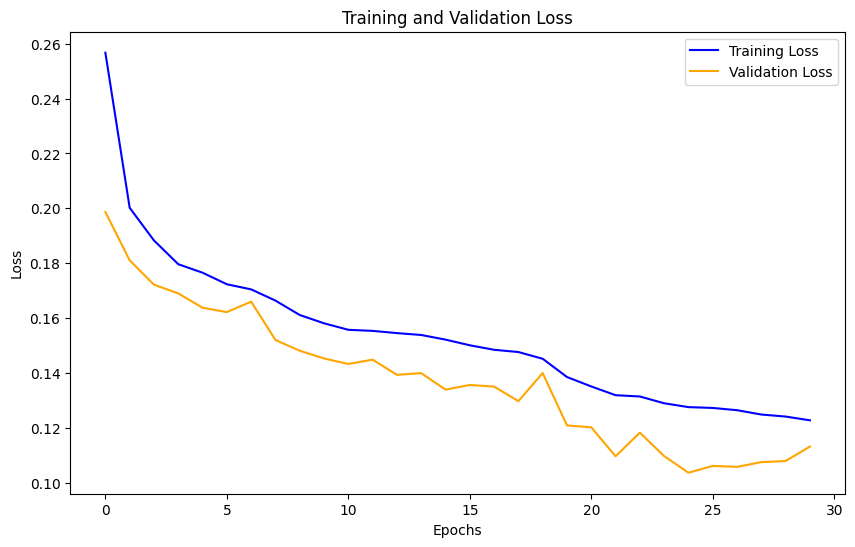

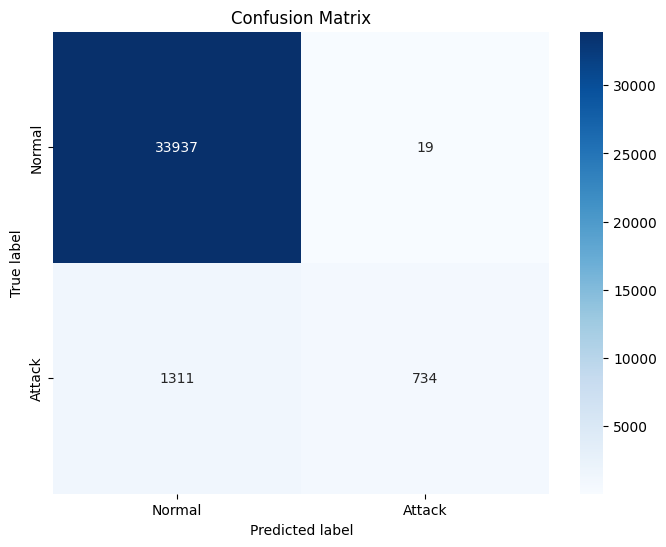

In [4]:
# Plot Training History
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Predict on test data
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


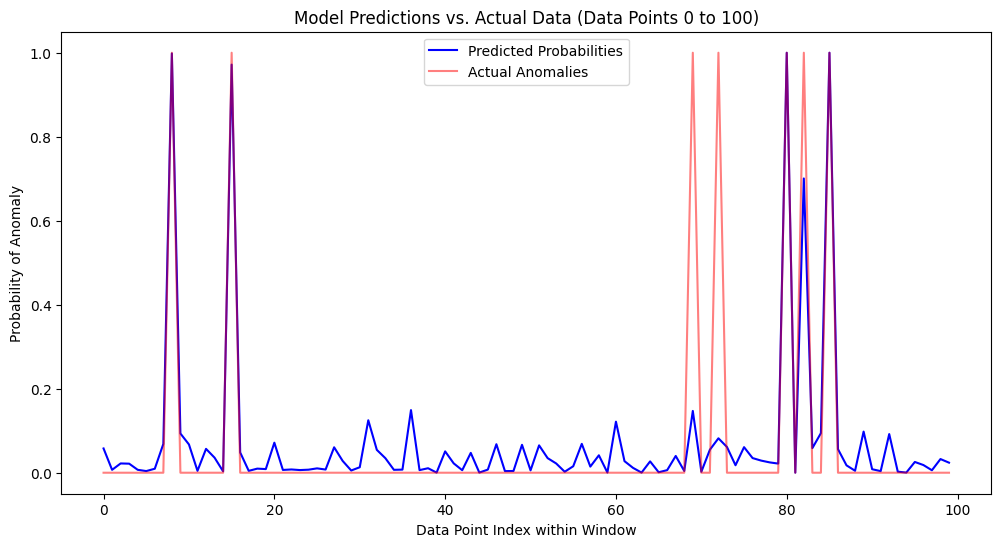

In [21]:
# Set the window for visualization
start_index = 0  # Adjust this to slide the window
window_size = 100  # Can be 50 or 100 as per your need

plt.figure(figsize=(12, 6))
plt.plot(y_pred[start_index:start_index + window_size], label='Predicted Probabilities', color='blue')
plt.plot(y_test[start_index:start_index + window_size], label='Actual Anomalies', color='red', alpha=0.5)
plt.title(f'Model Predictions vs. Actual Data (Data Points {start_index} to {start_index + window_size})')
plt.xlabel('Data Point Index within Window')
plt.ylabel('Probability of Anomaly')
plt.legend()
plt.show()


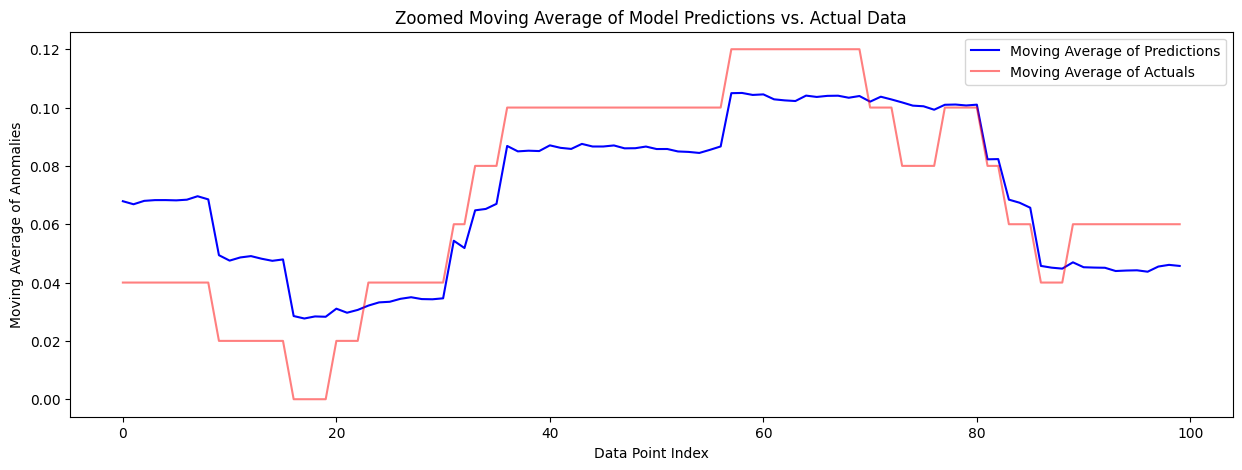

In [39]:
plt.figure(figsize=(15, 5))
plt.plot(moving_average(y_pred.flatten(), 50)[:100], label='Moving Average of Predictions', color='blue')  # First 100 points of moving average
plt.plot(moving_average(y_test, 50)[:100], label='Moving Average of Actuals', color='red', alpha=0.5)  # First 100 points of moving average
plt.title('Zoomed Moving Average of Model Predictions vs. Actual Data')
plt.xlabel('Data Point Index')
plt.ylabel('Moving Average of Anomalies')
plt.legend()
plt.show()


Loading dataset...
Mapping labels...
Assembling features...
Converting Spark DataFrame to NumPy arrays...
Normalizing features...
Splitting data into training and validation sets...
Building LSTM model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 32)           9728      
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 dense_4 (Dense)             (None, 20)                340       
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 13,225
Trainable params: 13,225
Non-trainable params: 0
___________________________________________

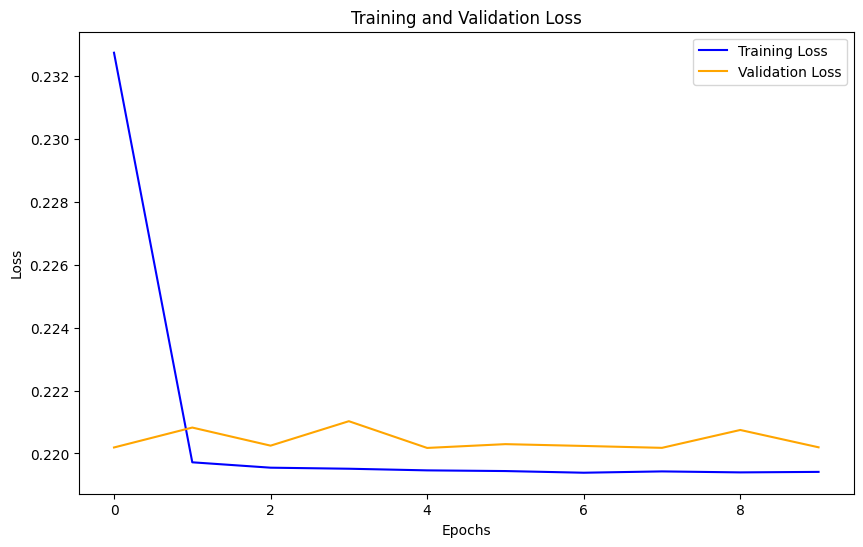

In [13]:
import os
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col
from pyspark.ml.feature import VectorAssembler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt

# Configurations
DATASET_FILE = "../dataset/preprocess_swat.csv"
MODEL_PATH = "models/swat_lstm_model"
SCALER_PATH = "scalers/swat_lstm_scaler"
VAL_DATA_PATH = "models/lstm_val_data.npz"
CATEGORY_MAPPING = {"Normal": 0, "Attack": 1}

# Initialize Spark Session
spark = SparkSession.builder.appName("SWaT_LSTM_Model_Local_Training").getOrCreate()

# Step 1: Load Dataset
print("Loading dataset...")
data = spark.read.csv(DATASET_FILE, header=True, inferSchema=True)

# Step 2: Map "Normal/Attack" to Binary Labels
print("Mapping labels...")
data = data.withColumn("Label", when(col("Normal/Attack") == "Normal", 0).otherwise(1)).drop("Normal/Attack")

# Step 3: Assemble Features
print("Assembling features...")
selected_features = [
    "FIT101", "LIT101", "MV101", "P101", "P102", 
    "AIT201", "AIT202", "AIT203", "FIT201", "MV201", 
    "P201", "P203", "P204", "P205", "P206", 
    "DPIT301", "FIT301", "LIT301", "MV301", "MV302", 
    "MV303", "MV304", "P302", "AIT401", "AIT402", 
    "FIT401", "LIT401", "P402", "UV401", "AIT501", 
    "AIT502", "AIT503", "AIT504", "FIT501", "FIT502", 
    "FIT503", "FIT504", "P501", "PIT501", "PIT502", 
    "PIT503", "FIT601", "P602"
]
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
feature_df = assembler.transform(data).select("features", "Label")

# Step 4: Convert Data to NumPy Arrays
print("Converting Spark DataFrame to NumPy arrays...")
feature_array = np.array(feature_df.select("features").rdd.map(lambda row: row[0]).collect())
label_array = np.array(feature_df.select("Label").rdd.flatMap(lambda x: x).collect())

# Step 5: Normalize Features
print("Normalizing features...")
scaler = MinMaxScaler()
feature_array = scaler.fit_transform(feature_array)

# # Save the scaler for future use
# os.makedirs("models", exist_ok=True)
# joblib.dump(scaler, f"models/{SCALER_PATH}.pkl")
# print(f"Scaler saved to models/{SCALER_PATH}.pkl")

# Step 6: Split into Training and Validation Sets
print("Splitting data into training and validation sets...")
x_train, x_val, y_train, y_val = train_test_split(feature_array, label_array, test_size=0.3, random_state=42)

# Reshape data for LSTM (3D input: [samples, timesteps, features])
history_size = 100 
x_train = np.array([x_train[i:i+history_size] for i in range(len(x_train) - history_size)])
y_train = y_train[history_size:] 
x_val = np.array([x_val[i:i+history_size] for i in range(len(x_val) - history_size)])
y_val = y_val[history_size:]

# Step 7: Build the LSTM Model
print("Building LSTM model...")
# def build_lstm_model(input_shape):
#     model = Sequential([
#         LSTM(64, input_shape=input_shape),
#         Dense(1, activation="sigmoid")  # Binary classification
#     ])
#     model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
#     return model

# # Define the complex LSTM model
def build_lstm_model(input_shape):
    model = tf.keras.models.Sequential([
        # Reduced number of units in the LSTM layer
        tf.keras.layers.LSTM(32, return_sequences=True, input_shape=input_shape,
                             dropout=0.1,  # Slightly reduced dropout
                             kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Maintain L2 regularization to help with overfitting
        # Second LSTM layer with fewer units
        tf.keras.layers.LSTM(16, dropout=0.1),  # Reduced complexity and dropout
        # Simplified Dense layer
        tf.keras.layers.Dense(20, activation='relu'),  # Reduced number of units
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust learning rate if necessary
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["accuracy"])
    return model

model = build_lstm_model(input_shape=(history_size, len(selected_features)))
model.summary()

# Step 8: Train the Model
print("Training the model...")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)

# Step 9: Save the Model
model.save(f"{MODEL_PATH}.keras")
print(f"Model saved to {MODEL_PATH}.keras")

# Step 10: Evaluate the Model
loss, accuracy = model.evaluate(x_val, y_val)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

# # Save Validation Data
# val_data_path = f"{MODEL_PATH}_val_data.npz"
# np.savez(val_data_path, X_test=x_val, y_test=y_val)
# print(f"Validation data saved to {val_data_path}")

# Step 11: Plot Training History
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["loss"], label="Training Loss", color="blue")
    plt.plot(history.history["val_loss"], label="Validation Loss", color="orange")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_training_history(history)


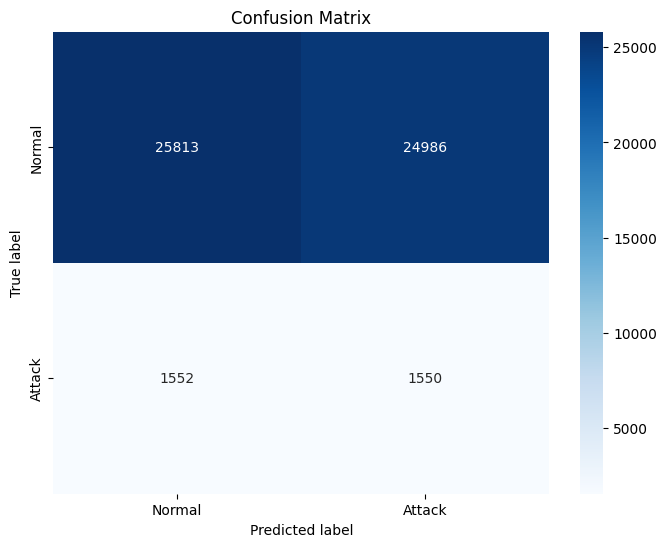

In [33]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Predict on test data
# y_pred = model.predict(X_test)
# y_pred_classes = (y_pred > 0.5).astype("int32")

# # Generate Confusion Matrix
# cm = confusion_matrix(y_test, y_pred_classes)

# Predict on test data
y_pred = model.predict(x_val)
y_pred_classes = (y_pred > 0.057369083166122437).astype("int32")

# Generate Confusion Matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [27]:
# Calculate mean and percentiles
mean_pred = np.mean(y_pred)
percentile_25 = np.percentile(y_pred, 25)
percentile_50 = np.percentile(y_pred, 50)  # Median
percentile_75 = np.percentile(y_pred, 75)

# Print statistics to check
print("Mean of predictions:", mean_pred)
print("25th percentile:", percentile_25)
print("Median (50th percentile):", percentile_50)
print("75th percentile:", percentile_75)


Mean of predictions: 0.057369564
25th percentile: 0.05736875534057617
Median (50th percentile): 0.057369083166122437
75th percentile: 0.05737033486366272


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10448\3834459760.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred, shade=True, color='green')


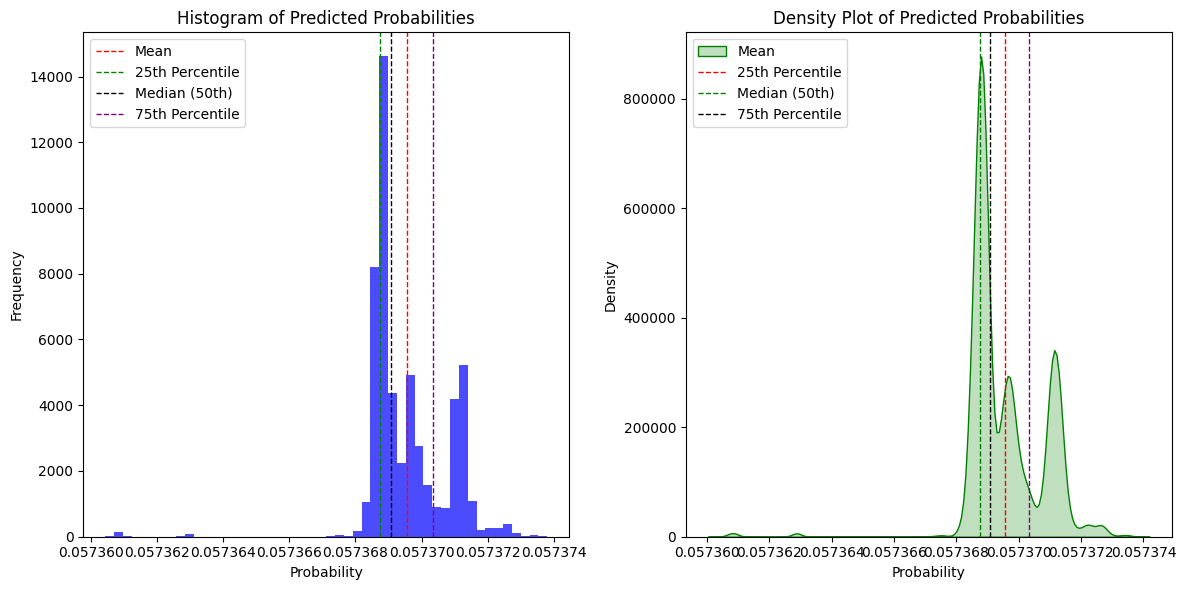

In [31]:
y_pred = model.predict(x_val).flatten()  # Flatten if necessary
# Calculate mean and percentiles
mean_pred = np.mean(y_pred)
percentile_25 = np.percentile(y_pred, 25)
percentile_50 = np.percentile(y_pred, 50)  # Median
percentile_75 = np.percentile(y_pred, 75)

plt.figure(figsize=(12, 6))
# Histogram
plt.subplot(1, 2, 1)
plt.hist(y_pred, bins=50, color='blue', alpha=0.7)
plt.axvline(mean_pred, color='red', linestyle='dashed', linewidth=1)
plt.axvline(percentile_25, color='green', linestyle='dashed', linewidth=1)
plt.axvline(percentile_50, color='black', linestyle='dashed', linewidth=1)
plt.axvline(percentile_75, color='purple', linestyle='dashed', linewidth=1)
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend(['Mean', '25th Percentile', 'Median (50th)', '75th Percentile'])

# Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(y_pred, shade=True, color='green')
plt.axvline(mean_pred, color='red', linestyle='dashed', linewidth=1)
plt.axvline(percentile_25, color='green', linestyle='dashed', linewidth=1)
plt.axvline(percentile_50, color='black', linestyle='dashed', linewidth=1)
plt.axvline(percentile_75, color='purple', linestyle='dashed', linewidth=1)
plt.title('Density Plot of Predicted Probabilities')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend(['Mean', '25th Percentile', 'Median (50th)', '75th Percentile'])

plt.tight_layout()
plt.show()

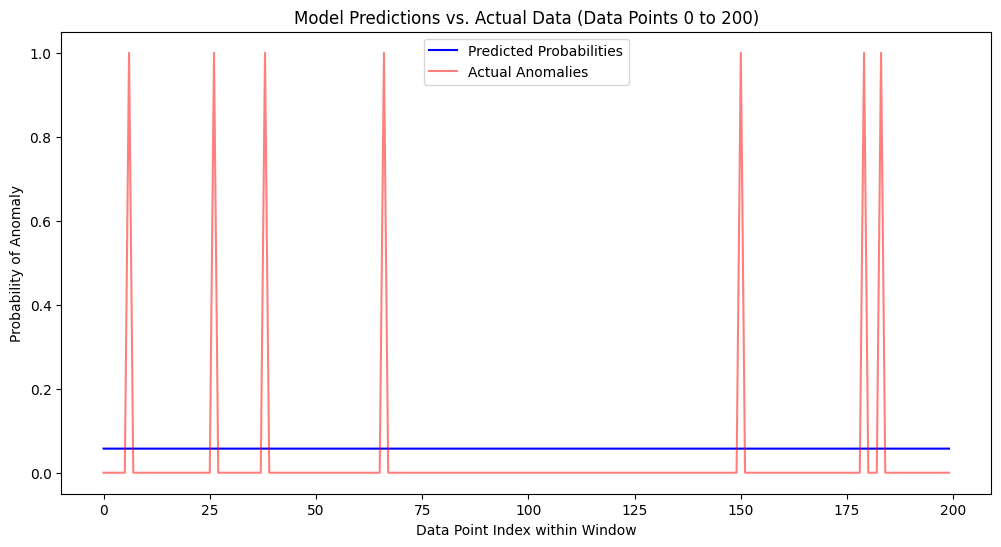

In [34]:
# Set the window for visualization
start_index = 0  # Adjust this to slide the window
window_size = 200  # Can be 50 or 100 as per your need

plt.figure(figsize=(12, 6))
plt.plot(y_pred[start_index:start_index + window_size], label='Predicted Probabilities', color='blue')
plt.plot(y_val[start_index:start_index + window_size], label='Actual Anomalies', color='red', alpha=0.5)
plt.title(f'Model Predictions vs. Actual Data (Data Points {start_index} to {start_index + window_size})')
plt.xlabel('Data Point Index within Window')
plt.ylabel('Probability of Anomaly')
plt.legend()
plt.show()


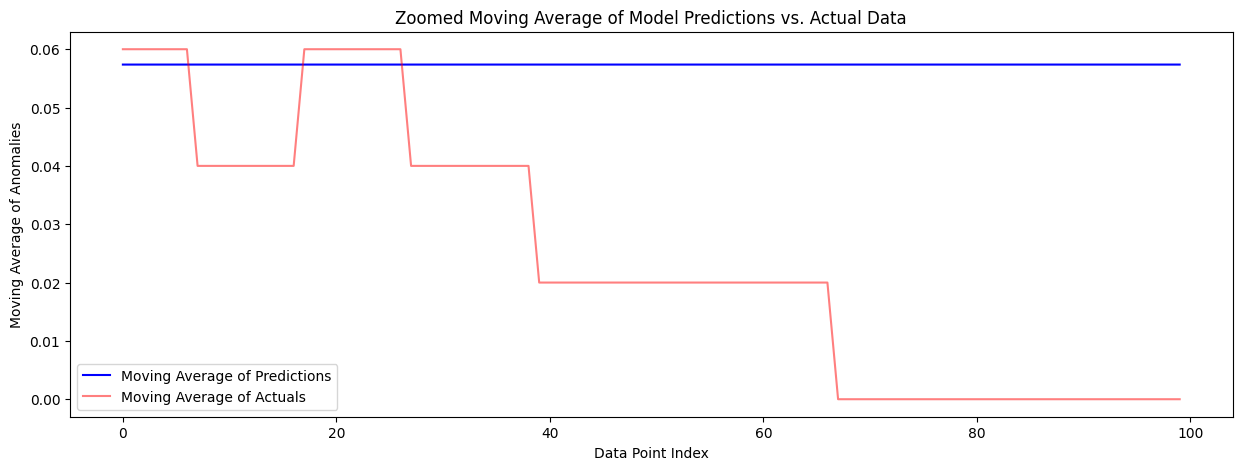

In [35]:
import numpy as np

def moving_average(data, window_size):
    """Calculate the moving average of the given data with a specified window size."""
    kernel = np.ones(window_size) / window_size
    return np.convolve(data, kernel, mode='valid')


plt.figure(figsize=(15, 5))
plt.plot(moving_average(y_pred.flatten(), 50)[:100], label='Moving Average of Predictions', color='blue')  # First 100 points of moving average
plt.plot(moving_average(y_val, 50)[:100], label='Moving Average of Actuals', color='red', alpha=0.5)  # First 100 points of moving average
plt.title('Zoomed Moving Average of Model Predictions vs. Actual Data')
plt.xlabel('Data Point Index')
plt.ylabel('Moving Average of Anomalies')
plt.legend()
plt.show()
